#AUDIO EMOTION CLASSIFICATION
<p>Kelompok A1</p>
Ni Kadek Dwi Marhaeni			(2208561008)</p>
Ida Ayu Made Putri Santiani			(2208561020)</p>
Ni Komang Ayu Juliana			(2208561046)</p>
Gede Brandon Abelio Ogaden		(2208561064)</p>
Ida Bagus Gede Basudewa Weda		(2208561077)</p>
</p>

##IMPORTS

In [ ]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 28.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import librosa
import os

##PREPROCESSING FUNCTIONS
<p>Trimming > Padding > Noise Reduction > Audio Augmentation

In [ ]:
def Trimming_padding(file_path, max_length=51200):
    audio, sample_rate = librosa.load(file_path, sr=None)
    audio, _ = librosa.effects.trim(audio)
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        pad_width = max_length - len(audio)
        audio = np.pad(audio, pad_width=(0, pad_width), mode='constant', constant_values=0)
    return audio, sample_rate

In [ ]:
def augment_audio(audio, sample_rate):
    pitch_shifted = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=np.random.uniform(-4, 4))
    stretched = librosa.effects.time_stretch(pitch_shifted, rate=np.random.uniform(0.8, 1.2))
    return stretched

##FEATURE EXTRACTION FUNCTIONS
<p>MFCC > Chroma > Spectral Contrast > Zero-Crossing Rate

In [ ]:
def extract_mfcc(audio, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    if mfccs.shape[1] > 100:
        mfccs = mfccs[:, :100]
    else:
        pad_width = 100 - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    return mfccs

In [ ]:
def extract_additional_features(audio, sample_rate, max_frames=100):
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_chroma=12, n_fft=2048, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_fft=2048, hop_length=512)
    zcr = librosa.feature.zero_crossing_rate(y=audio, hop_length=512)

    def pad_feature(feature, max_frames):
        if feature.shape[1] > max_frames:
            return feature[:, :max_frames]
        else:
            pad_width = max_frames - feature.shape[1]
            return np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=0)

    chroma = pad_feature(chroma, max_frames)
    spectral_contrast = pad_feature(spectral_contrast, max_frames)
    zcr = pad_feature(zcr, max_frames)

    return chroma, spectral_contrast, zcr

In [ ]:
def process_and_extract_features(file_path, max_length=51200):
    audio, sample_rate = Trimming_padding(file_path, max_length)
    audio = augment_audio(audio, sample_rate)
    mfccs = extract_mfcc(audio, sample_rate)
    chroma, spectral_contrast, zcr = extract_additional_features(audio, sample_rate)
    features = np.hstack([mfccs.flatten(), chroma.flatten(), spectral_contrast.flatten(), zcr.flatten()])
    return features

##PREPROCESSING & FEATURE EXTRACTION

In [ ]:
main_dir = '/content/drive/MyDrive/Data Audio/Audio_Dataset'

In [ ]:
X = []
y = []

In [ ]:
for emotion_folder in os.listdir(main_dir):
    emotion_path = os.path.join(main_dir, emotion_folder)
    for audio_file in os.listdir(emotion_path):
        file_path = os.path.join(emotion_path, audio_file)
        features = process_and_extract_features(file_path)
        X.append(features)
        y.append(emotion_folder)

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
df = pd.DataFrame(X_scaled, columns=[f"feature_{i}" for i in range(X_scaled.shape[1])])
df['label'] = y

csv_file_path = '/content/drive/MyDrive/Data Audio/mfcc_features.csv'
df.to_csv(csv_file_path, index=False)
print(f"MFCC features saved to {csv_file_path}")

MFCC features saved to /content/drive/MyDrive/Data Audio/mfcc_features.csv


##DATA PREPARATIONS FOR MODELLING

In [ ]:
from keras.utils import to_categorical

In [ ]:
# 1. Membaca dataset dengan fitur MFCC dan label emosi
# Misalnya, Anda sudah memisahkan kolom MFCC dan kolom target emosi
file_path = '/content/drive/MyDrive/Data Audio/mfcc_features.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_3291,feature_3292,feature_3293,feature_3294,feature_3295,feature_3296,feature_3297,feature_3298,feature_3299,label
0,0.444849,0.521748,0.433609,0.391086,0.424561,0.448515,0.450575,0.518756,0.538189,0.469108,...,5.287182,3.267992,1.829030,1.019109,1.192395,1.347191,1.726624,2.071980,2.107519,anger_emotion
1,0.213725,0.708667,1.061314,1.177190,1.055350,0.758616,0.609570,0.530095,0.445752,0.430375,...,2.158176,2.770143,3.037784,2.440093,1.589766,-0.422428,-0.407676,-0.391983,-0.377617,anger_emotion
2,-0.873099,-0.242911,0.572982,1.048286,1.118548,0.970177,0.754162,0.600603,0.585435,0.675381,...,3.301106,3.319053,2.652290,1.749709,-0.438200,-0.422428,-0.407676,-0.391983,-0.377617,anger_emotion
3,-1.208506,-0.556335,0.091015,0.540104,0.722640,0.785834,0.901636,1.085171,1.071049,0.940563,...,-0.502417,-0.485025,-0.470870,-0.455498,-0.438200,-0.422428,-0.407676,-0.391983,-0.377617,anger_emotion
4,0.460391,0.939544,1.179333,1.111843,1.130920,1.196747,1.234190,1.347791,1.576091,1.753802,...,-0.108949,-0.204187,-0.372862,-0.455498,-0.438200,-0.422428,-0.407676,-0.391983,-0.377617,anger_emotion


In [ ]:
df.shape

(9617, 3301)

In [ ]:
# Separate features (X) and labels (y) from DataFrame
X = df.iloc[:, :-1].values  # Features (MFCC) as numpy array
y = df['label'].values  # Labels as numpy array

In [ ]:
# Encode label menjadi numerik
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Reshape X to 3D array (height, width, channels) for CNN input
height = 20  # Assuming you extracted 20 MFCC features per frame
width = X.shape[1] // height
X = X.reshape(X.shape[0], height, width, 1)

In [ ]:
# Convert labels to one-hot encoded format
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes=num_classes)

In [ ]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Example assuming X_train and X_test have shape (11322, 20, 165, 1)
X_train = X_train.reshape(X_train.shape[0], 20, 165, 1)
X_test = X_test.reshape(X_test.shape[0], 20, 165, 1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7693, 20, 165, 1)
(1924, 20, 165, 1)


In [ ]:
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

##HYPER PARAMETER TUNING


In [ ]:
def create_model(learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(20, 165, 1), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

In [ ]:
# Define the parameter grid
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [50]
}

In [ ]:
# Create and run the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Print the best parameters and results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"{mean} ({std}) with: {param}")

Best: 0.5343828528969619 using {'batch_size': 16, 'epochs': 50, 'model__learning_rate': 0.001}
0.5343828528969619 (0.005553118775023505) with: {'batch_size': 16, 'epochs': 50, 'model__learning_rate': 0.001}
0.19862265445783522 (0.0029247913713422763) with: {'batch_size': 16, 'epochs': 50, 'model__learning_rate': 0.01}
0.19511261542079616 (0.009917914581342615) with: {'batch_size': 16, 'epochs': 50, 'model__learning_rate': 0.1}
0.5341228424965458 (0.004971620145655756) with: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.001}
0.2819552275268399 (0.11973453313574225) with: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.01}
0.20213238938914282 (0.0057283765120123235) with: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.1}
0.5336037340129082 (0.010912445557353566) with: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.001}
0.19225239964764285 (0.0062633264479186965) with: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.01}
0.20200030

##CNN MODEL

In [ ]:
# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(20, 165, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolution to fully connected layers
model.add(Flatten())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Dense (fully connected) layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 20, 165, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 82, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 41, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 41, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         655,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 765,317 (2.92 MB)

 Trainable params: 765,317 (2.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 62s 125ms/step - accuracy: 0.2350 - loss: 1.6021 - val_accuracy: 0.4262 - val_loss: 1.3332
Epoch 2/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 80s 121ms/step - accuracy: 0.4036 - loss: 1.3644 - val_accuracy: 0.5026 - val_loss: 1.1933
Epoch 3/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 59s 122ms/step - accuracy: 0.4654 - loss: 1.2513 - val_accuracy: 0.5322 - val_loss: 1.1228
Epoch 4/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 83s 125ms/step - accuracy: 0.5059 - loss: 1.1796 - val_accuracy: 0.5385 - val_loss: 1.0696
Epoch 5/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - accuracy: 0.5194 - loss: 1.1407 - val_accuracy: 0.5327 - val_loss: 1.1435
Epoch 6/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step - accuracy: 0.5542 - loss: 1.0858 - val_accuracy: 0.5473 - val_loss: 1.0652
Epoch 7/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 81s 120ms/step - accuracy: 0.5691 - loss: 1.0258 - val_accuracy: 0.5639 - val_loss: 1.0487
Epoch 8/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step - accuracy: 0.5852 - loss: 1

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
model.save("/content/drive/MyDrive/Data Audio/model.keras")

In [ ]:
imported_model = keras.models.load_model("/content/drive/MyDrive/Data Audio/model.keras")

In [ ]:
loss, accuracy = imported_model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.5340 - loss: 2.7140
Test Loss: 2.6288135051727295
Test Accuracy: 0.5519750714302063


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Predict the labels for your test data
predictions = imported_model.predict(X_test)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert the one-hot encoded test labels to class labels
true_labels = np.argmax(y_test, axis=1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step


              precision    recall  f1-score   support

           0       0.70      0.67      0.68       393
           1       0.45      0.50      0.47       360
           2       0.49      0.46      0.47       377
           3       0.50      0.51      0.50       372
           4       0.62      0.60      0.61       422

    accuracy                           0.55      1924
   macro avg       0.55      0.55      0.55      1924
weighted avg       0.55      0.55      0.55      1924



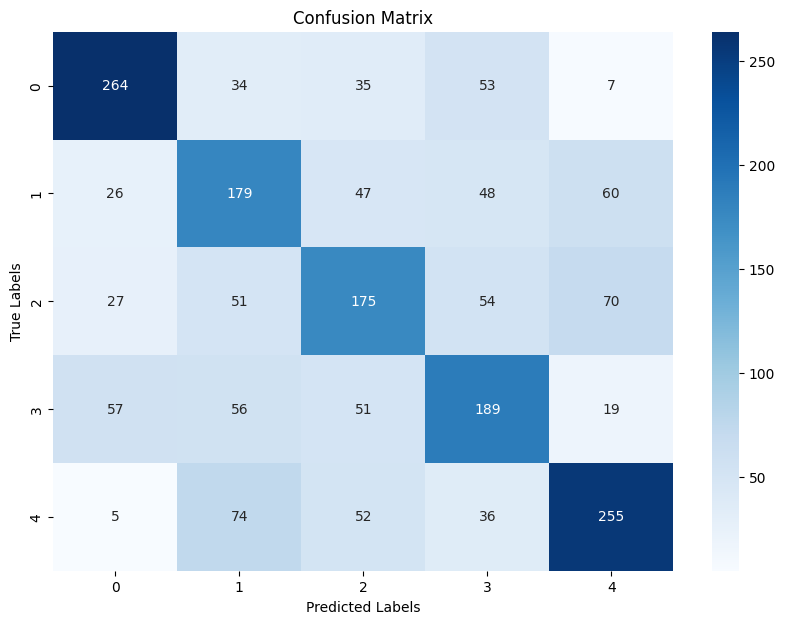

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print classification report for detailed metrics
print(classification_report(true_labels, predicted_labels))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()